#### 在训练集内训练HMM模型，然后在测试集里查看预测的结果
来源：https://zhuanlan.zhihu.com/p/51418002 <br/>
学习要点：<br/>
（1）类、对象这种编程风格：\__init\__函数、def \_name这样的只在类内部调用的函数、self.这样的内部可以共享的数据(Class里面用到的变量都要在\__init\__函数里面的self.定义一下)；<br/>
（2）用itertools.product()生成一个笛卡尔积的对象； <br/>
（3）tqdm(循环对象)，一般用在for循环中，用来显示进度条； <br/>
（4）numpy的一些用法：np.column_stack()、np.row_stack()、np.argmax()

2018-12-13 18:56:36,740 __main__     INFO     >>> Extracting Features
2018-12-13 18:56:36,740 __main__     INFO     >>> Extracting Features
2018-12-13 18:56:36,740 __main__     INFO     >>> Extracting Features
2018-12-13 18:56:36,743 __main__     INFO     Features extraction Completed <<<
2018-12-13 18:56:36,743 __main__     INFO     Features extraction Completed <<<
2018-12-13 18:56:36,743 __main__     INFO     Features extraction Completed <<<
100%|██████████| 70/70 [01:21<00:00,  1.16s/it]


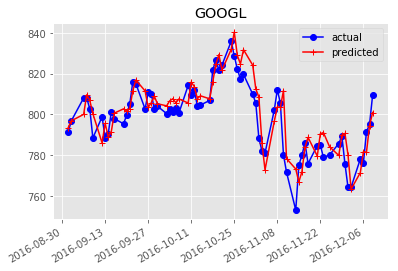

[793.5962656734694,
 796.8930200408164,
 800.0193823775512,
 809.5788297204082,
 806.8632770632653,
 800.4001628979593,
 786.1210812653062,
 795.6304385918368,
 789.1372331408163,
 791.6222753265306,
 800.6506731020409,
 802.7449033367345,
 801.6326530612245,
 802.8952345102041,
 811.6530612244898,
 816.8035660510207,
 811.4727008918368,
 803.4664047897959,
 805.7209966265307,
 808.8773881224489,
 805.2399759510204,
 804.1878451183674,
 806.6428571428571,
 807.6448979591837,
 805.7209966265307,
 807.5747480877551,
 805.570666455102,
 815.8315543938776,
 813.6170832693878,
 807.7150478306123,
 809.097869167347,
 807.6348675306123,
 815.8716751061224,
 824.5593519489796,
 829.2488959551023,
 821.6734693877552,
 831.7840882795919,
 840.211224489796,
 828.8079949897959,
 824.6896222653061,
 831.6337571061223,
 824.1084215571428,
 812.5248317244898,
 808.406459,
 786.1010204081633,
 772.8740696081633,
 796.5723589632653,
 803.6668249775511,
 803.4664047897959,
 811.6530612244898,
 778.39532

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Usage: analyse_data.py --company=<company>
"""
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from docopt import docopt
 
# args = docopt(doc=__doc__, argv=None, help=True, version=None, options_first=False)
 
# Supress warning in hmmlearn
warnings.filterwarnings("ignore")
# 将绘图风格改为ggplot
plt.style.use('ggplot')
 
 
class StockPredictor(object):
    # __init__：在类实例化时就会被调用的函数
    def __init__(self, company, test_size=0.33,
                 n_hidden_states=4, n_latency_days=10,
                 n_steps_frac_change=50, n_steps_frac_high=10,
                 n_steps_frac_low=10):
        self._init_logger()
        self.company = company
        self.n_latency_days = n_latency_days
 
        # 高斯HMM模型的初始化
        self.hmm = GaussianHMM(n_components=n_hidden_states)
        # 训练数据和测试数据
        self._split_train_test_data(test_size)
        # 所有可能结果的初始化
        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)
 
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
 
    ### __init__时就调用 ###
    def _split_train_test_data(self, test_size):
        data = pd.read_csv(
            'data/company_data/{company}.csv'.format(company=self.company))
        _train_data, test_data = train_test_split(
            data, test_size=test_size, shuffle=False)
        # Class内部共享的变量，训练集_train_data和测试集_test_data
        self._train_data = _train_data
        self._test_data = test_data
 
    # 从原始的交易数据到特征数据的计算，结果是一个array数组
    @staticmethod
    def _extract_features(data):
        open_price = np.array(data['open'])
        close_price = np.array(data['close'])
        high_price = np.array(data['high'])
        low_price = np.array(data['low'])
        # 计算收盘价、高价和低价的分数变化
        # 这会用到一个特征
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price
 
        return np.column_stack((frac_change, frac_high, frac_low))
 
    ### 给外面调用的函数 ###
    # 在train_data中，fit模型
    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vector = self._extract_features(self._train_data)
        self._logger.info('Features extraction Completed <<<')
 
        self.hmm.fit(feature_vector)
 
    ### __init__时就调用 ###
    # 算完后使得self._possible_outcomes成为一个定值----单期内三个特征值的所有可能取值组合(笛卡尔乘积获得)
    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
 
        # itertools.product()生成一个笛卡尔积的对象，np.array(list())后就可以生成一个二维数组
        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))
 
    # 在test_data中，从self._possible_outcomes中找到fit出来的model认为概率最大的那组特征
    # hmm.score的输入是(过去n_lanteny_days的特征+待检验的特征)
    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_end_index: previous_data_start_index]
        previous_data_features = self._extract_features(
            previous_data)
 
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
 
        return most_probable_outcome
 
    # 由开盘价open_price预测收盘价close_price的函数
    # day_index是_test_data的索引号(代码里的意思是看测试集里多少天的预测情况)
    def predict_close_price(self, day_index):
        open_price = self._test_data.iloc[day_index]['open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(
            day_index)
        return open_price * (1 + predicted_frac_change)
 
    ### 给外面调用的函数 ###
    # 给定预测天数days，查看训练出来的HMM的预测情况
    def predict_close_prices_for_days(self, days, with_plot=False):
        predicted_close_prices = []
        for day_index in tqdm(range(days)):  # tqdm，可以用来显示进度条，一般用在for循环的循环对象上
            predicted_close_prices.append(self.predict_close_price(day_index))
 
        if with_plot:
            test_data = self._test_data[0: days]
            days = np.array(test_data['date'], dtype="datetime64[ms]")
            actual_close_prices = test_data['close']
 
            fig = plt.figure()
 
            axes = fig.add_subplot(111)
            axes.plot(days, actual_close_prices, 'bo-', label="actual")
            axes.plot(days, predicted_close_prices, 'r+-', label="predicted")
            axes.set_title('{company}'.format(company=self.company))
 
            fig.autofmt_xdate()
 
            plt.legend()
            plt.show()
 
        return predicted_close_prices
 
 
stock_predictor = StockPredictor('GOOGL')
stock_predictor.fit()
stock_predictor.predict_close_prices_for_days(70, with_plot=True)  # 在test集里看70天的预测